In [23]:
from corus import load_lenta
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import warnings
import time
warnings.filterwarnings("ignore")

Курсовая работа по теме "Предварительный анализ данных и построение признаков в задачах классификации текстов"
    
Целью работы является создания эффективной модели классификации новостей по заголовку.

Задачи:

1.Загрузить датасет

2.Создать на основании взятого датасета свой датасет, подходящий для решения задачи и проанализировать его

3.Провести обработку текста датасета для его использования в построении модели

4.Разбить выборку на тестовую и обучающую

5.Обучить модели и сравнить их
    
Набор данных - датасет новостей с новостного сайта Lenta.ru с 1990 года. В датасете даны: тег новости, заголовок, текст и топик. Для обучения модели тег будет взят как основная переменная, а по заголовоку модель будет классифицировать новость в одну из категорий - политика, общество, спорт, экономика, культура и преступления. Для этого из датасета будут отобраны все теги с подходящей темой (тег "Финансы компаний" будет классифицироваться в категорию "Экономика" или тег "Выборы" в "Политика")

In [13]:
records = load_lenta('lenta-ru-news.csv.gz')
main_tags = {'Политика':'Политика', 'Выборы':'Политика', 'Общество':'Общество','Зимние виды':'Спорт', 'Хоккей':'Спорт',  'Футбол':'Спорт',\
             'Аналитика рынка':'Экономика', 'Госэкономика':'Экономика', 'Рынки':'Экономика', 'Госрегулирование':'Экономика',\
             'Финансы компаний':'Экономика', 'Книги':'Культура',\
             'Музыка':'Культура',  'Внешний вид':'Культура', 'Стиль':'Культура','Искусство':'Культура', 'Мемы':'Культура',\
             'Кино':'Культура', 'ТВ и радио':'Культура', 'Криминал':'Правосудие', 'Преступность':'Правосудие', 'Полиция и спецслужбы':'Правосудие',\
            'Преступная Россия':'Правосудие', 'Киберпреступность':'Правосудие'}




tags, titles = [], []
for record in records:
    tag = record.tags
    if tag in main_tags:
        tags += [main_tags[tag]]
        titles += [record.title]
news = pd.DataFrame({'tag':tags, 'title':titles})

In [14]:
news

,tag,title
0,Общество,Названы регионы России с самой высокой смертно...
1,Спорт,Австрия не представила доказательств вины росс...
2,Политика,В США раскрыли сумму расходов на расследование...
3,Общество,Хакеры рассказали о планах Великобритании зами...
4,Общество,Полицейские из Солсбери описали одеревеневшего...
...,...,...
125103,Культура,Заложен первый камень Великого Египетского музея
125104,Правосудие,Выходец из Сомали планировал теракт в Портленде
125105,Общество,Сеульские власти повысят рождаемость путем орг...
125106,Правосудие,В убийстве американского радиоведущего признал...


Для датасета мы взяли 2 столбца - tag и title. В поле tag содержится тег новости, а в поле title - заголовок статьи. Всего юыло взято 125107 тегов и заголовков

Проанализируем полученный датасет на предмет пропусков

In [15]:
news.isnull().sum()

tag      0
title    0
dtype: int64

Пропущенные значения отстуствуют

Рассмотрим расперделение новостей по категориям

<Axes: xlabel='tag', ylabel='count'>

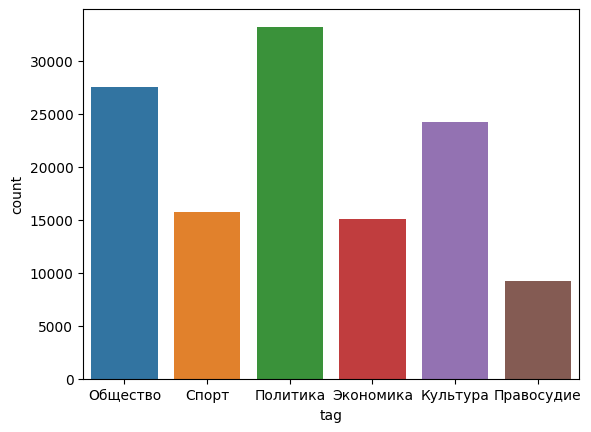

In [16]:
sns.countplot(news['tag'])

Рассмотрев полученное распределение значений можно заметить неравномерное распределение признаков, но оно не критично, поэтому не имеет смысл обрабатывать данные для изменения их соотношения друг к другу

Разбиваем текст на слова, удаляет стоп-слова, а затем применяет лемматизацию к каждому слову. Лемматизация - это процесс преобразования слова в его базовую форму

In [17]:
import nltk
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer


In [18]:
morph = MorphAnalyzer()
stopwords_ru = stopwords.words("russian")

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [morph.parse(word)[0].normal_form for word in words if word not in stopwords_ru]
    
    return ' '.join(words)

news['title'] = news['title'].apply(preprocess_text)
news

,tag,title
0,Общество,назвать регион россия сам высокий смертность рак
1,Спорт,австрия представить доказательство вина россий...
2,Политика,в сша раскрыть сумма расход расследование « ро...
3,Общество,хакер рассказать план великобритания заминиров...
4,Общество,полицейский солсбери описать одеревенеть скрип...
...,...,...
125103,Культура,заложить первый камень великий египетский музей
125104,Правосудие,выходец сомали планировать теракт портленд
125105,Общество,сеульский власть повысить рождаемость путём ор...
125106,Правосудие,в убийство американский радиоведущий признатьс...


полученные заголовки намного удобнее и эффективнее для обучения модели

Векторизуем полученные данные для последующего обучения модели

In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(news['title'])

Разделим данные на обучающую и тестовую выборки. В данном случае будет использаван метод train_test_split из библиотеки sklearn. Этот метод наиболее удобен, так как нет риска смещения в выборке и нет 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, news['tag'], test_size=0.2, random_state=42)

Обучим несколько моделей с помощью разных алгоритмов(Логистическая регрессия, Наивный Байесовский классификатор, RandomForest,  Градиентный бустинг) и сравним их

In [21]:
import pandas as pd

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

names = ["Логистическая регрессия", "Наивный Байесовский классификатор",
         "RandomForest",  "Градиентный бустинг"]

classifiers = [
    LogisticRegression(solver='lbfgs', max_iter=1000),
    MultinomialNB(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
    ]

In [24]:
scores = []
times = []
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    times += [train_time]
    score = clf.score(X_test, y_test)
    scores.append(score)
    print(f'{name} ready')

Логистическая регрессия ready
Наивный Байесовский классификатор ready
RandomForest ready
Градиентный бустинг ready


In [25]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df['time'] = times
df.sort_values(by=["score"], ascending=False, inplace=True)
df

,name,score,time
0,Логистическая регрессия,0.810087,27.170488
1,Наивный Байесовский классификатор,0.795980,0.216453
2,RandomForest,0.763448,636.312684
3,Градиентный бустинг,0.643873,1347.127507


Наиболее эффективными как по времени, так и по метрики оказались две модели - логистическая и Наивная Байесовская. Попробуем улучшить результаты, взяв выборку на 1000 элементов для каждого тега.

In [37]:
news1 = news.groupby('tag').sample(n=1000, replace=True)
news1

,tag,title
77732,Культура,диск элвис пресли возглавить британский хит-па...
124814,Культура,the strokes анонсировать новый альбом
18152,Культура,брэд питта попасть авария
21086,Культура,фото пенис убитый рэпер тупак выставить продажа
72301,Культура,« би-би-си » показать возможный сценарий конфл...
...,...,...
34776,Экономика,два треть россиянин стать экономить продукт
65468,Экономика,сша пообещать украина миллиард доллар кредитны...
67822,Экономика,новак допустить строительство газопровод « пос...
121626,Экономика,слух задержание абрамович опустить акция « нор...


In [45]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(news1['title'])
X_train, X_test, y_train, y_test = train_test_split(X, news1['tag'], test_size=0.2, random_state=42)

In [46]:
scores = []
times = []
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    times += [train_time]
    score = clf.score(X_test, y_test)
    scores.append(score)
    print(f'{name} ready')

Логистическая регрессия ready
Наивный Байесовский классификатор ready
RandomForest ready
Градиентный бустинг ready


In [47]:
df2 = pd.DataFrame()
df2['name'] = names
df2['score'] = scores
df2['time'] = times
df2.sort_values(by=["score"], ascending=False, inplace=True)
df2

,name,score,time
0,Логистическая регрессия,0.715833,1.017745
1,Наивный Байесовский классификатор,0.695833,0.011000
2,RandomForest,0.649167,8.906862
3,Градиентный бустинг,0.626667,26.208369


При уменьшении выборки время обучения моделей сильно уменьшилось, но это привело к ухудшению качества модели, что можно понять из ухудшения оценок моделей относительно прошлой версии. Попробуем расширить выборку до 4000 элементов для каждого тега

In [48]:
news2 = news.groupby('tag').sample(n=4000, replace=True)
news2

,tag,title
68403,Культура,актёр « игра престол » перепутать имя меч назв...
95271,Культура,группа « чайф » предупредить мошеннический кон...
10627,Культура,звезда « игра престол » пожениться
123471,Культура,голый жена ник кейв попасть обложка альбом слу...
82353,Культура,мединский обсудить глава мвд охрана музей полиция
...,...,...
116564,Экономика,центробанк снизить официальный курс евро полрубль
60599,Экономика,дефицит бюджет сша вырасти 27 процент
112828,Экономика,минэкономразвития предложить заморозить зарпла...
69805,Экономика,в вэб рассказать беспрецедентный падение доход...


Разделим данные на обучающую и тестовую выборки и обучим модели

In [49]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(news2['title'])
X_train, X_test, y_train, y_test = train_test_split(X, news2['tag'], test_size=0.2, random_state=42)

In [50]:
scores = []
times = []
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    times += [train_time]
    score = clf.score(X_test, y_test)
    scores.append(score)
    print(f'{name} ready')

Логистическая регрессия ready
Наивный Байесовский классификатор ready
RandomForest ready
Градиентный бустинг ready


In [51]:
df3 = pd.DataFrame()
df3['name'] = names
df3['score'] = scores
df3['time'] = times
df3.sort_values(by=["score"], ascending=False, inplace=True)
df3

,name,score,time
0,Логистическая регрессия,0.800625,4.696791
1,Наивный Байесовский классификатор,0.785625,0.038001
2,RandomForest,0.756875,57.621466
3,Градиентный бустинг,0.675000,155.471686


Построение выборки на таком количестве элементов позволило построить модели схожей эффективности, при этом время их обучения сократилось в несколько раз. Рассматривая полученные модели можно заметить, что хотя модель Логистической регрессии и показала наилучший результат, но метод Наивного Байеса справилась с это задачей в несколько раз быстрее, при это качество полученной модели лишь немного слабее 

Результатом исследования показали, что машинное обучение может быть эффективно
использовано для классификации текстов, а именно классификации новостей по тегам с помощью заголовков. При этом важно отметить что выбор правильного алгоритма имеет критическое значение для построения корректно и эффективно работующей модели.